In [30]:
## all imports up here, rerun this block when adding
import pandas as pd
import numpy as np
import cv2 as cv
import sys
sys.path.insert(0, '../Synthetic Group Creation/')
from groups_generators import GroupsGenerator
sys.path.insert(0, '../Synthetic Group Creation/')
import config as cfg  


In [59]:
ratings_df = pd.read_csv("../../Datasets/XWines_Slim_1K_wines_150K_ratings/XWines_Slim_150K_ratings.csv", low_memory=False, encoding="utf-8", memory_map=True)
wines_df = pd.read_csv("../../Datasets/XWines_Slim_1K_wines_150K_ratings/XWines_Slim_1K_wines.csv", low_memory=False, encoding="utf-8", memory_map=True)

In [ ]:
wines_df = pd.read_csv("../../Datasets/All-XWines_Full_100K_wines_21M_ratings/XWines_Full_100K_wines.csv", low_memory=False, encoding="utf-8", memory_map=True)
ratings_df = pd.read_csv("../../Datasets/All-XWines_Full_100K_wines_21M_ratings/XWines_Full_21M_ratings.csv", low_memory=False, encoding="utf-8", memory_map=True)

In [67]:
ratings_df.head()

,RatingID,UserID,WineID,Vintage,Rating,Date
0,143,1356810,103471,1950,4.5,2021-11-02 20:52:59
1,199,1173759,111415,1951,5.0,2015-08-20 17:46:26
2,348,1164877,111395,1952,5.0,2020-11-13 05:40:26
3,374,1207665,111433,1953,5.0,2017-05-05 06:44:13
4,834,1075841,111431,1955,5.0,2016-09-14 20:18:38


In [69]:
wines_df.shape

(1007, 17)

**Group settings**

In [73]:
group_sizes_to_create = cfg.group_sizes_to_create
group_similarity_to_create = cfg.group_similarity_to_create
group_number = cfg.group_number

# Similarity evaluation

In [77]:
# Counts the amount of ratings per user
ratings_per_user = ratings_df.groupby('UserID').size()

# Calculate the average number of ratings per user
average_number_of_rating = ratings_per_user.mean()

#Round Value
rounded_average_number_of_rating = round(average_number_of_rating)
print(rounded_average_number_of_rating)

14


In [80]:
# Count the number of ratings for each user
user_counts = ratings_df['UserID'].value_counts()

# Filter users who have at least the specified number of ratings
filtered_users = user_counts[user_counts <= rounded_average_number_of_rating].index

# Filter the DataFrame to keep only these users
ratings_df = ratings_df[ratings_df['UserID'].isin(filtered_users)]
print(ratings_df)

        RatingID   UserID  WineID Vintage  Rating                 Date
3            374  1207665  111433    1953     5.0  2017-05-05 06:44:13
4            834  1075841  111431    1955     5.0  2016-09-14 20:18:38
5            876  1211463  111395    1955     5.0  2021-12-02 23:12:49
6           1005  1076348  111433    1955     4.5  2021-06-19 19:53:56
8           1029  1225931  111431    1955     5.0  2017-04-24 01:41:52
...          ...      ...     ...     ...     ...                  ...
149993  21013409  1086949  111484    N.V.     4.5  2019-04-14 17:31:49
149994  21013430  1026866  111479    N.V.     4.0  2014-11-22 15:00:48
149995  21013438  1000052  111468    N.V.     4.5  2021-12-22 21:03:51
149997  21013494  1218581  113690    N.V.     3.5  2019-04-14 17:45:08
149999  21013509  1059173  111479    N.V.     5.0  2019-09-08 15:42:28

[70480 rows x 6 columns]


In [83]:
# computing similarity between each pair of users
user_matrix = ratings_df.pivot_table(columns='WineID', index='UserID', values='Rating')
user_id_set = set(ratings_df['UserID'])
user_id_indexes = user_matrix.index.values
user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)

## Visualization of the similarity distribution

Text(0.5, 0, "Pearson's Correlation Coeficient")

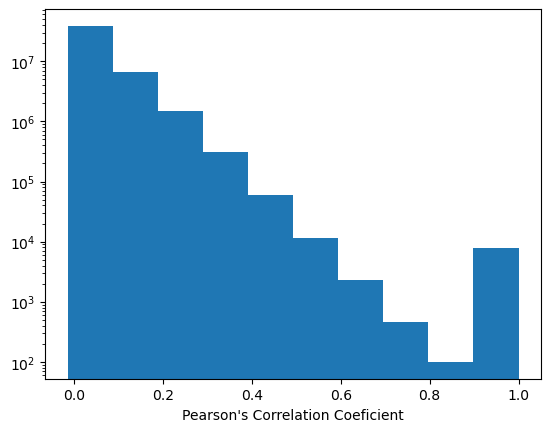

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sim_matrix.flatten())
plt.yscale("log")
plt.xlabel("Pearson's Correlation Coeficient")

## Group creation

In [117]:
from groups_generators import GroupsGenerator
user_id_set = sorted(user_id_set)
group_list = list()

for group_type in group_similarity_to_create:
    grpGenerator = GroupsGenerator.getGroupsGenerator(group_type)
    current_list = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, group_sizes_to_create, group_number)
    group_list = group_list + current_list

group_dict = dict()
for group_id, group in zip(range(len(group_list)), group_list):
    group_dict[group_id] = group

20
40
60
20
40
60
20
40
60
20
40
60


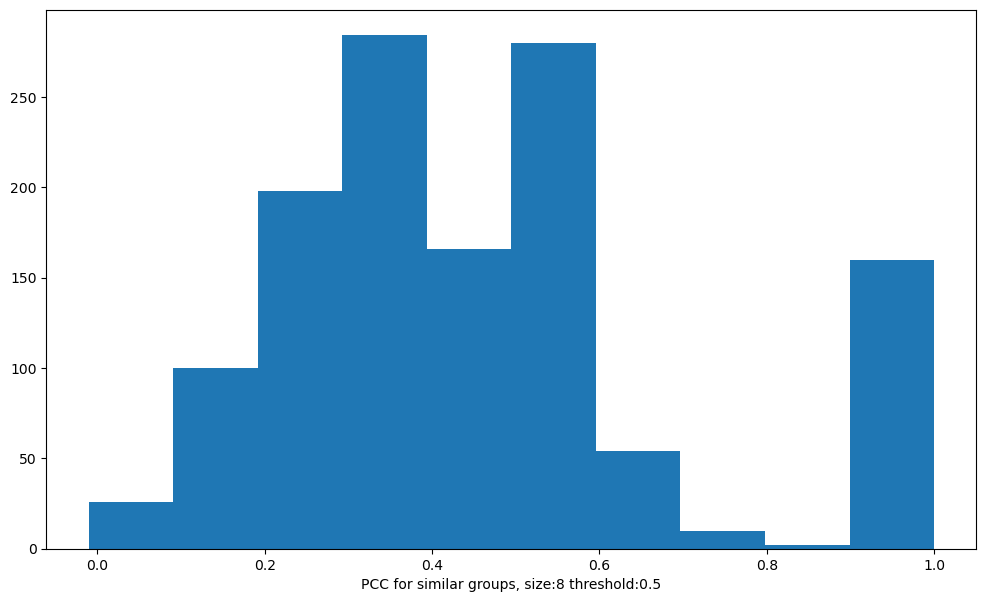

In [122]:
group_similarity = "similar"
group_size = 8
histogram_list = []
for gid in group_dict.keys():
    g = group_dict[gid]
    if g["group_similarity"] == group_similarity and g["group_size"] == group_size:
        member_index = [user_id_indexes.tolist().index(member) for member in g["group_members"]]
        s = sim_matrix[member_index]
        histogram_list.extend(s[:,member_index].flatten().tolist())

        
plt.hist(histogram_list)
#plt.yscale("log")
plt.xlabel("PCC for "+group_similarity+" groups, size:"+str(group_size)+" threshold:"+str(cfg.similar_threshold))    
plt.savefig("pcc_"+group_similarity+"_"+str(group_size)+"_"+str(int(cfg.similar_threshold*10))+".png", dpi=300)

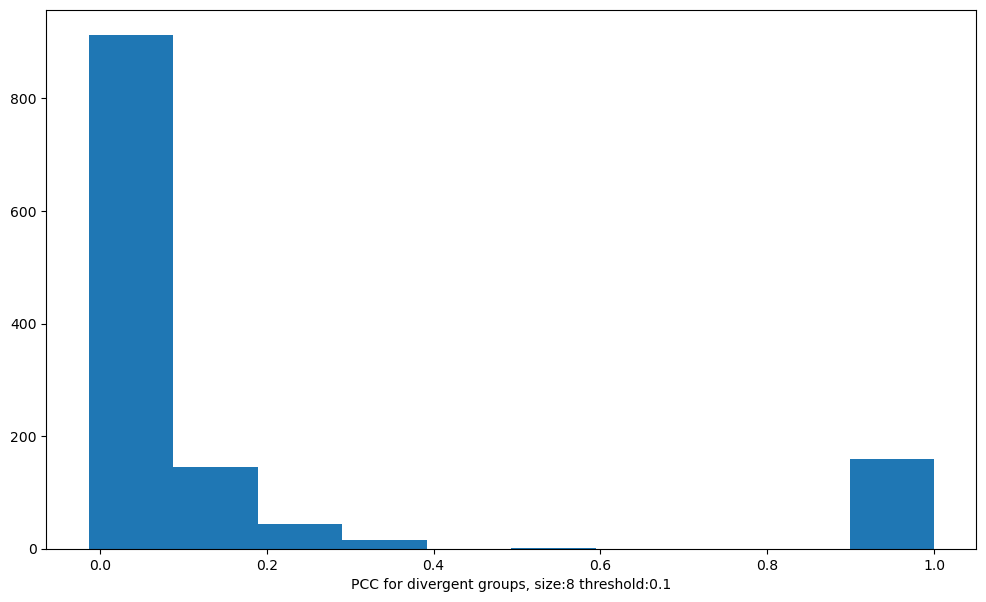

In [129]:
group_similarity = "divergent"
group_size = 8
histogram_list = []
for gid in group_dict.keys():
    g = group_dict[gid]
    if g["group_similarity"] == group_similarity and g["group_size"] == group_size:
        member_index = [user_id_indexes.tolist().index(member) for member in g["group_members"]]
        s = sim_matrix[member_index]
        histogram_list.extend(s[:,member_index].flatten().tolist())

        
plt.hist(histogram_list)
#plt.yscale("log")
plt.xlabel("PCC for "+group_similarity+" groups, size:"+str(group_size)+" threshold:"+str(cfg.dissimilar_threshold))    
plt.savefig("pcc_"+group_similarity+"_"+str(group_size)+"_"+str(int(cfg.dissimilar_threshold*10))+".png", dpi=300)

### Comparing groups internal average similarity between the different types and sizes 

In [151]:
groups_list = list()
for group in group_dict:
    groups_list.append(
        {
            'group_id': group,
            'group_size': group_dict[group]['group_size'],
            'group_similarity': group_dict[group]['group_similarity'],
            'group_members': group_dict[group]['group_members'],
            'avg_similarity': group_dict[group]['avg_similarity']
        }
    )

groups_df = pd.DataFrame.from_records(groups_list)
display(groups_df.head(10))

,group_id,group_size,group_similarity,group_members,avg_similarity
0,0,2,random,"[1011730, 1222696]",-0.011088
1,1,2,random,"[1465808, 1891978]",-0.003386
2,2,2,random,"[1855392, 1642793]",-0.004753
3,3,2,random,"[1950031, 1160507]",0.156548
4,4,2,random,"[1367385, 1207951]",-0.010529
5,5,2,random,"[1028380, 1496287]",0.093958
6,6,2,random,"[1562442, 1183964]",-0.008479
7,7,2,random,"[1276338, 1133004]",0.077521
8,8,2,random,"[1020486, 1285964]",0.169644
9,9,2,random,"[1156175, 1369086]",-0.009043


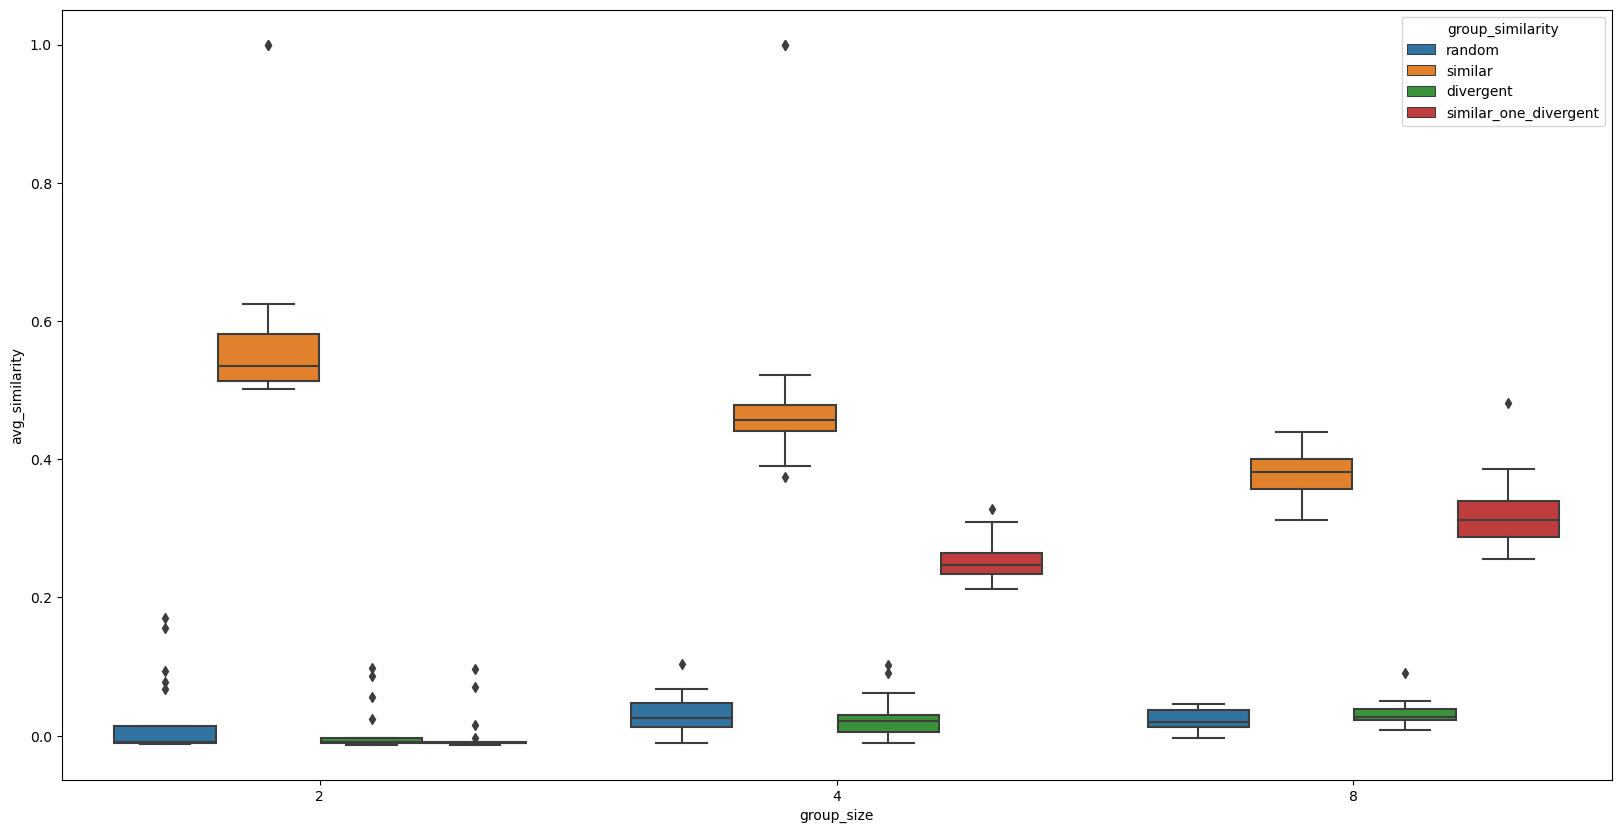

In [154]:
import seaborn as sns


plt.rcParams["figure.figsize"] = (20,10)
sns.boxplot(x = groups_df['group_size'],
            y = groups_df['avg_similarity'],
            hue = groups_df['group_similarity'])
import matplotlib.pyplot as plt